# Face Expression Dataset
## Description: 
*The data is downloaded from Kaggle. The data consists of 48x48 pixel images of faces. The faces have been automatically registered so that  the face is more or less centred and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression into one of six 
categories (0 = Angry, 1 = Fear, 2 = Happy, 3 = Sad, 4 = Surprise, 5 = Neutral).*
### Summary:
*This model can be used to make predictions on the expression/emotion of person. Initially we start of with EDA on the dataset and look into the kind of images present in different classes. It was noted that the size was 38,000 images spread across train, validation and test. Different Image augmentations are experimented and the dataset is made ready to be fed to the model. Post this the modelling takes place where the class weights along with callback are defined. After modelling we save the model and history so that it can be recovered later. Later Model predictions and evaluations are performed. It was seen that the optimal seems to be somewhere between Epoch 15-20 so the weights can be recoverd here. Also the model has slighty overfit. 4 classes angry, fear, neutral and sad have performed well with an accuracy of > 90%, happy has an accuracy of 84% and surprise at 78%. The overall accuracy of the model on the test dataset is 91%.*

In [1]:
#Importing the necessary Libraries
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

### Exploratory Data Analysis

*We declare the train and testing data folder paths, image size and shape, batch_size and different classes present in the dataset.*

In [3]:
train_dir = './../data/train/'
val_dir = './../data/val/'
test_dir = './../data/test/'

image_size = (48, 48)
image_shape = image_size + (3, )

batch_size = 128

classes = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

*Here are some images from all the classes in the dataset.*

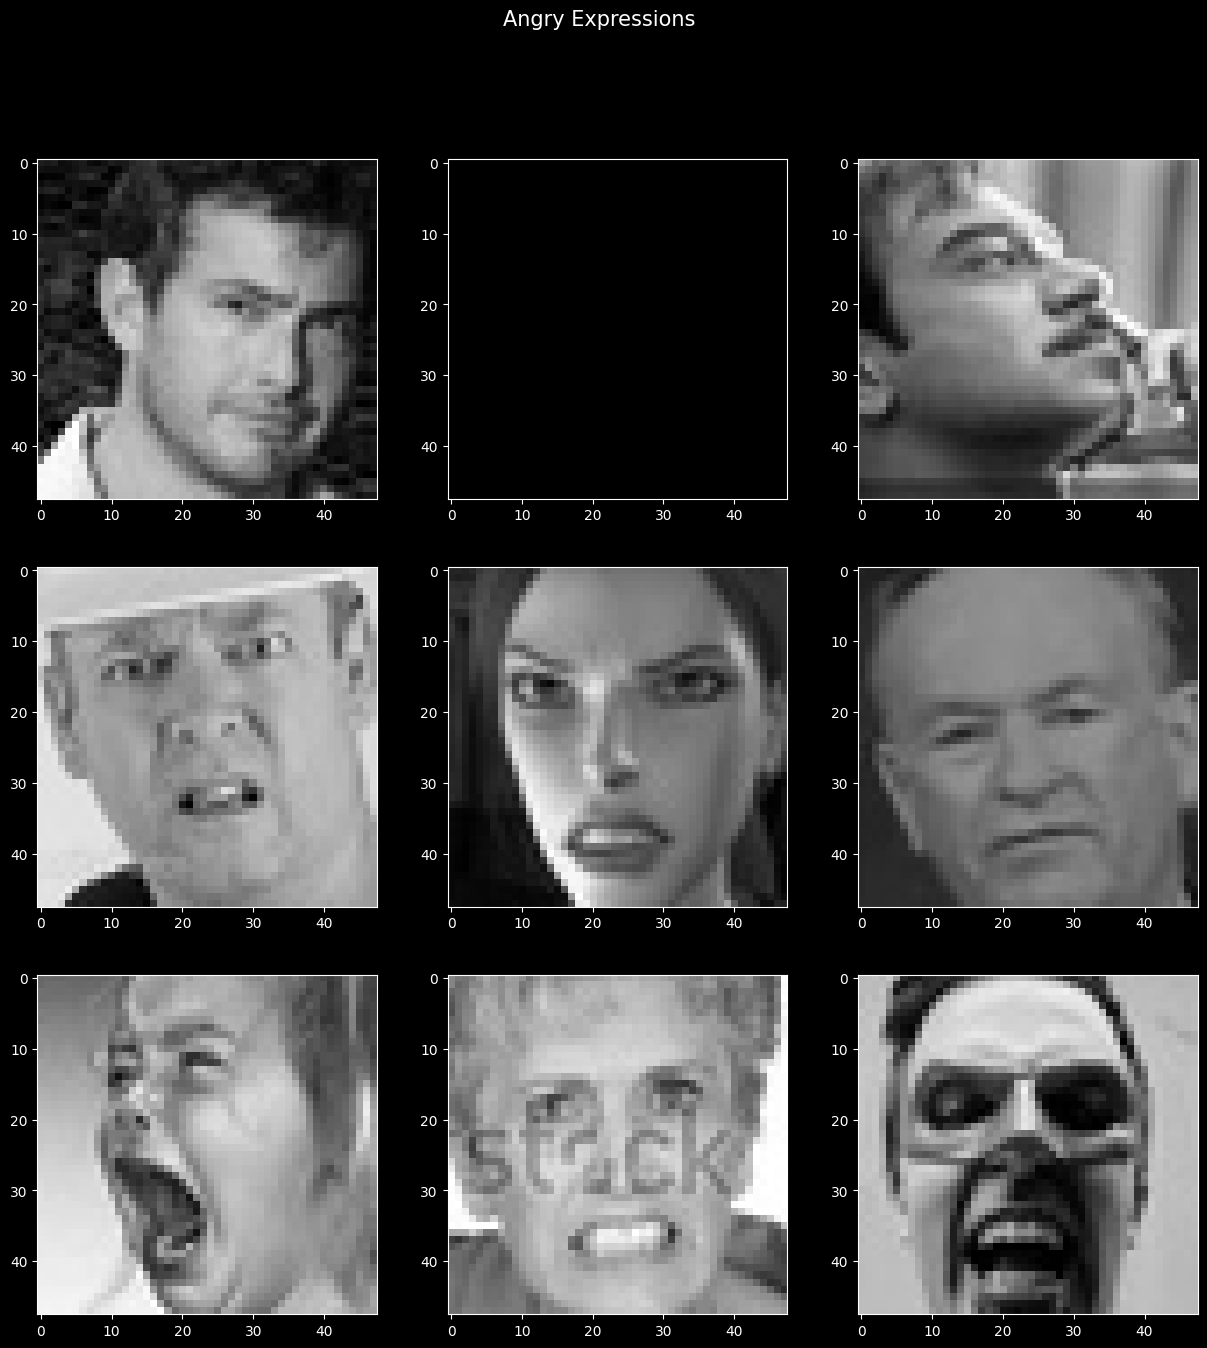

In [4]:
expression = 'angry'
plt.style.use('dark_background')
plt.figure(figsize = (15, 15))
plt.suptitle('Angry Expressions', fontsize = 15)
for i in range(1, 10, 1):
    plt.subplot(3, 3 ,i)
    plt.grid(False)
    img = load_img(train_dir + expression + '/' +
                  os.listdir(train_dir + expression)[i], target_size = (image_size))
    plt.imshow(img)
plt.show()

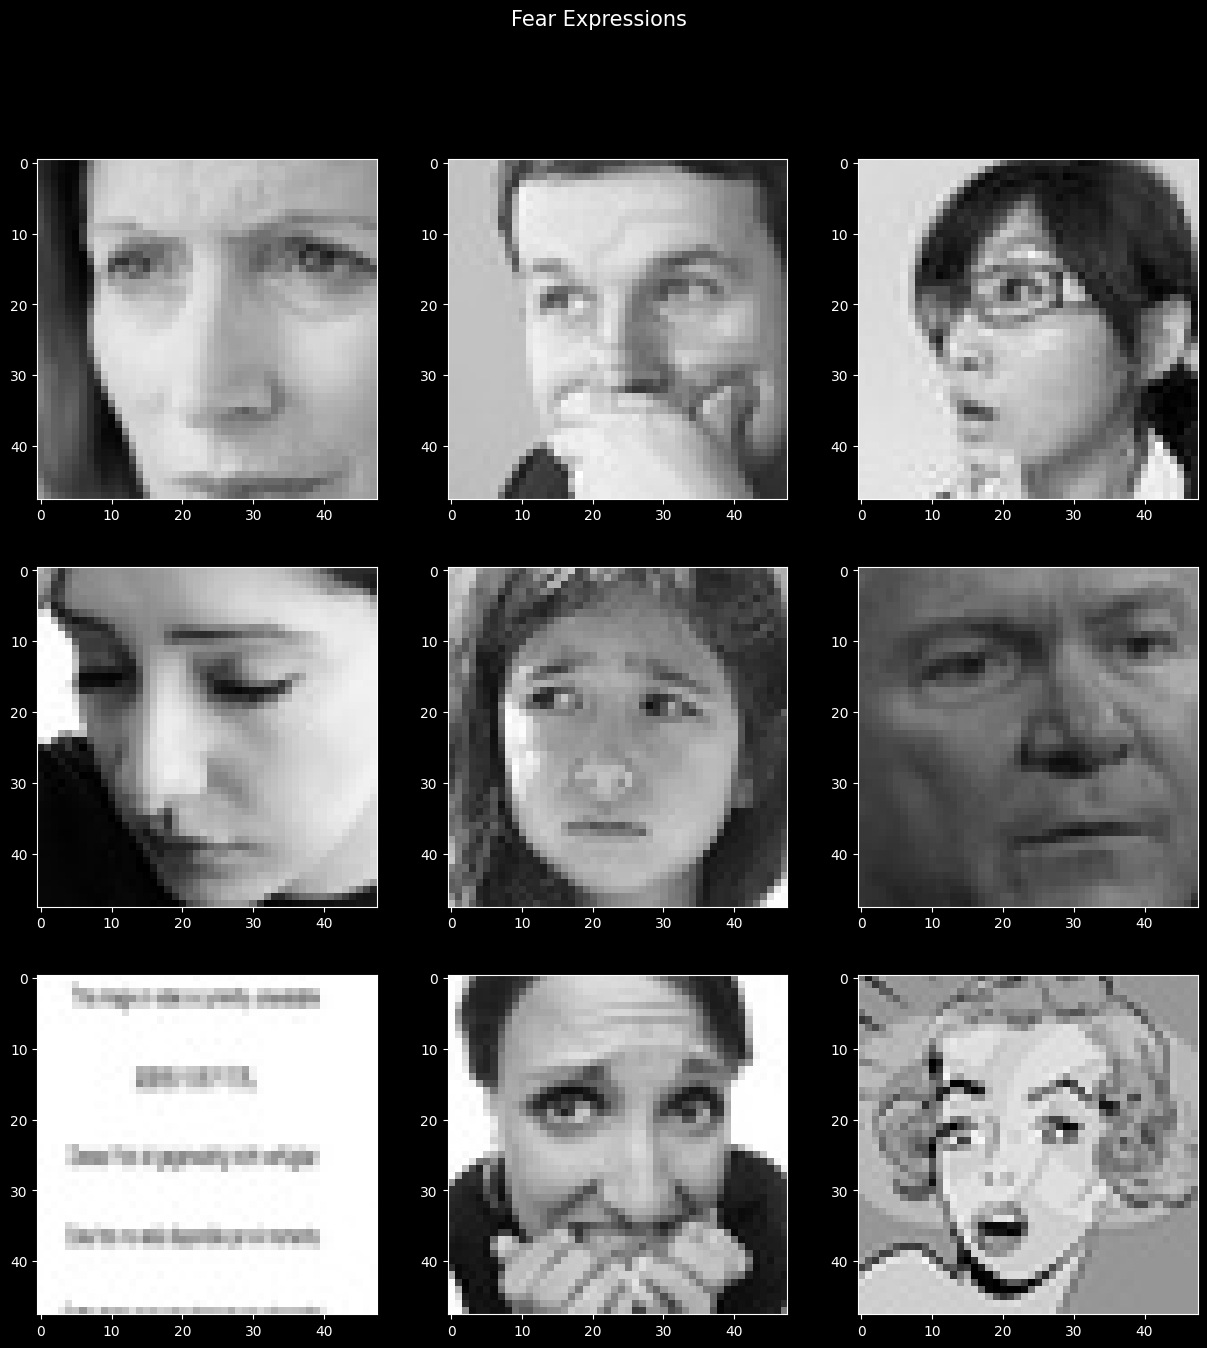

In [5]:
expression = 'fear'
plt.style.use('dark_background')
plt.figure(figsize = (15, 15))
plt.suptitle('Fear Expressions', fontsize = 15)
for i in range(1, 10, 1):
    plt.subplot(3, 3 ,i)
    plt.grid(False)
    img = load_img(train_dir + expression + '/' +
                  os.listdir(train_dir + expression)[i], target_size = (image_size))
    plt.imshow(img)
plt.show()

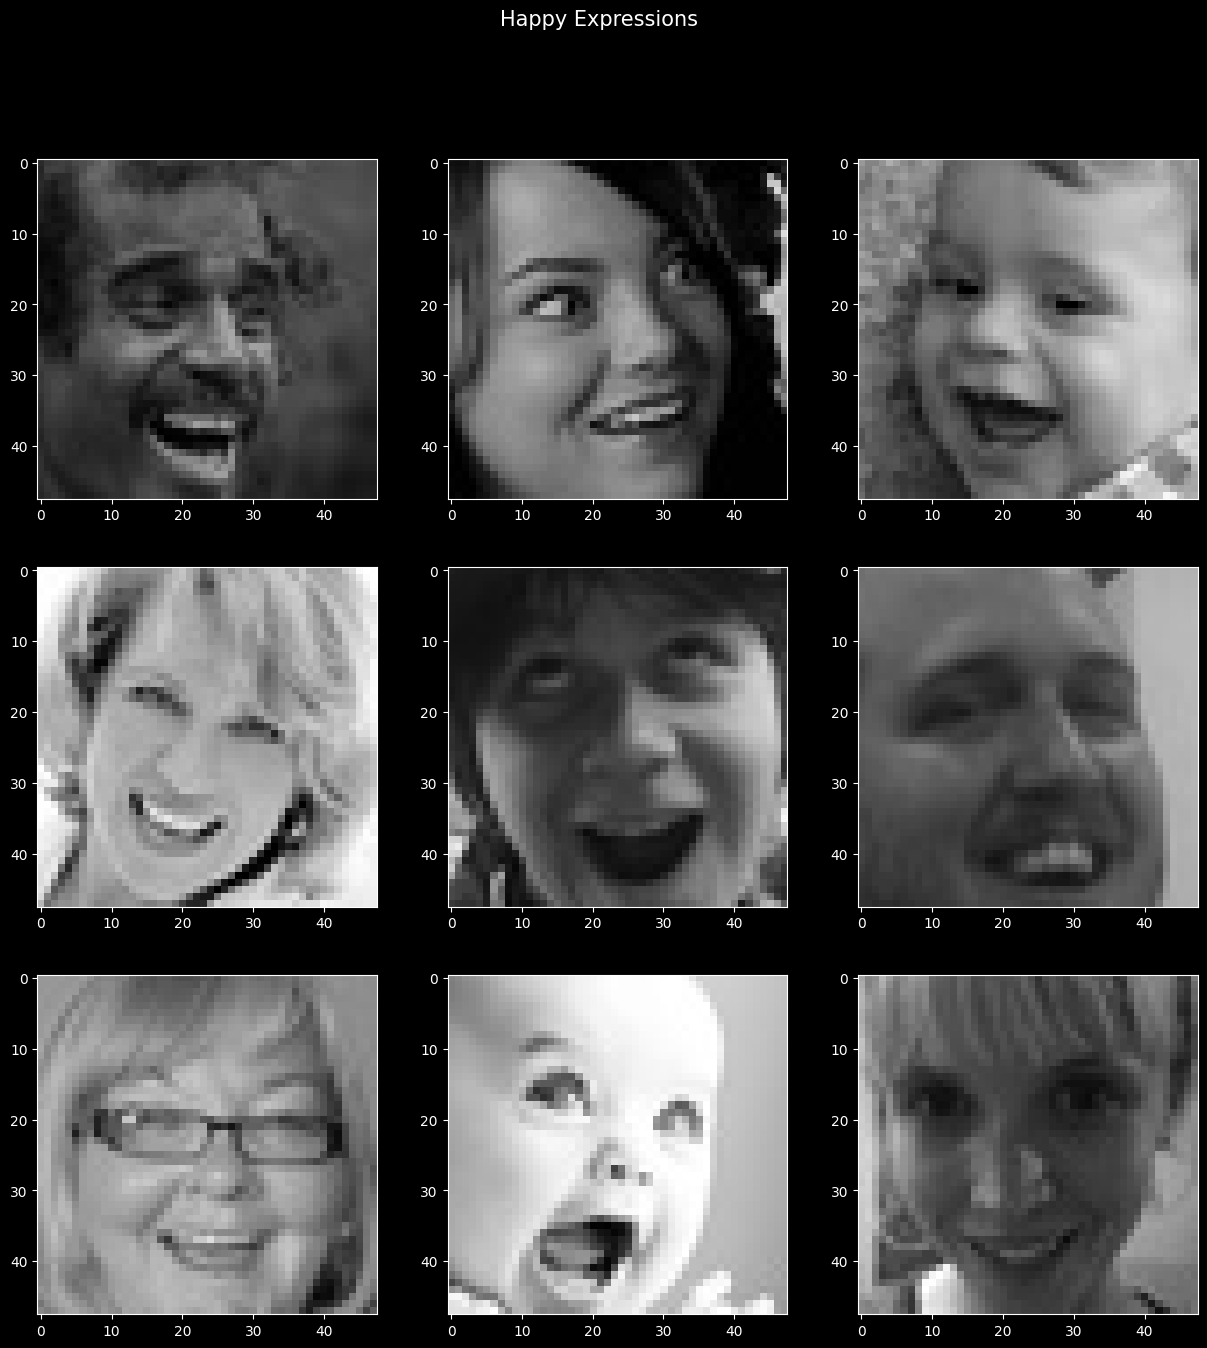

In [6]:
expression = 'happy'
plt.style.use('dark_background')
plt.figure(figsize = (15, 15))
plt.suptitle('Happy Expressions', fontsize = 15)
for i in range(1, 10, 1):
    plt.subplot(3, 3 ,i)
    plt.grid(False)
    img = load_img(train_dir + expression + '/' +
                  os.listdir(train_dir + expression)[i], target_size = (image_size))
    plt.imshow(img)
plt.show()

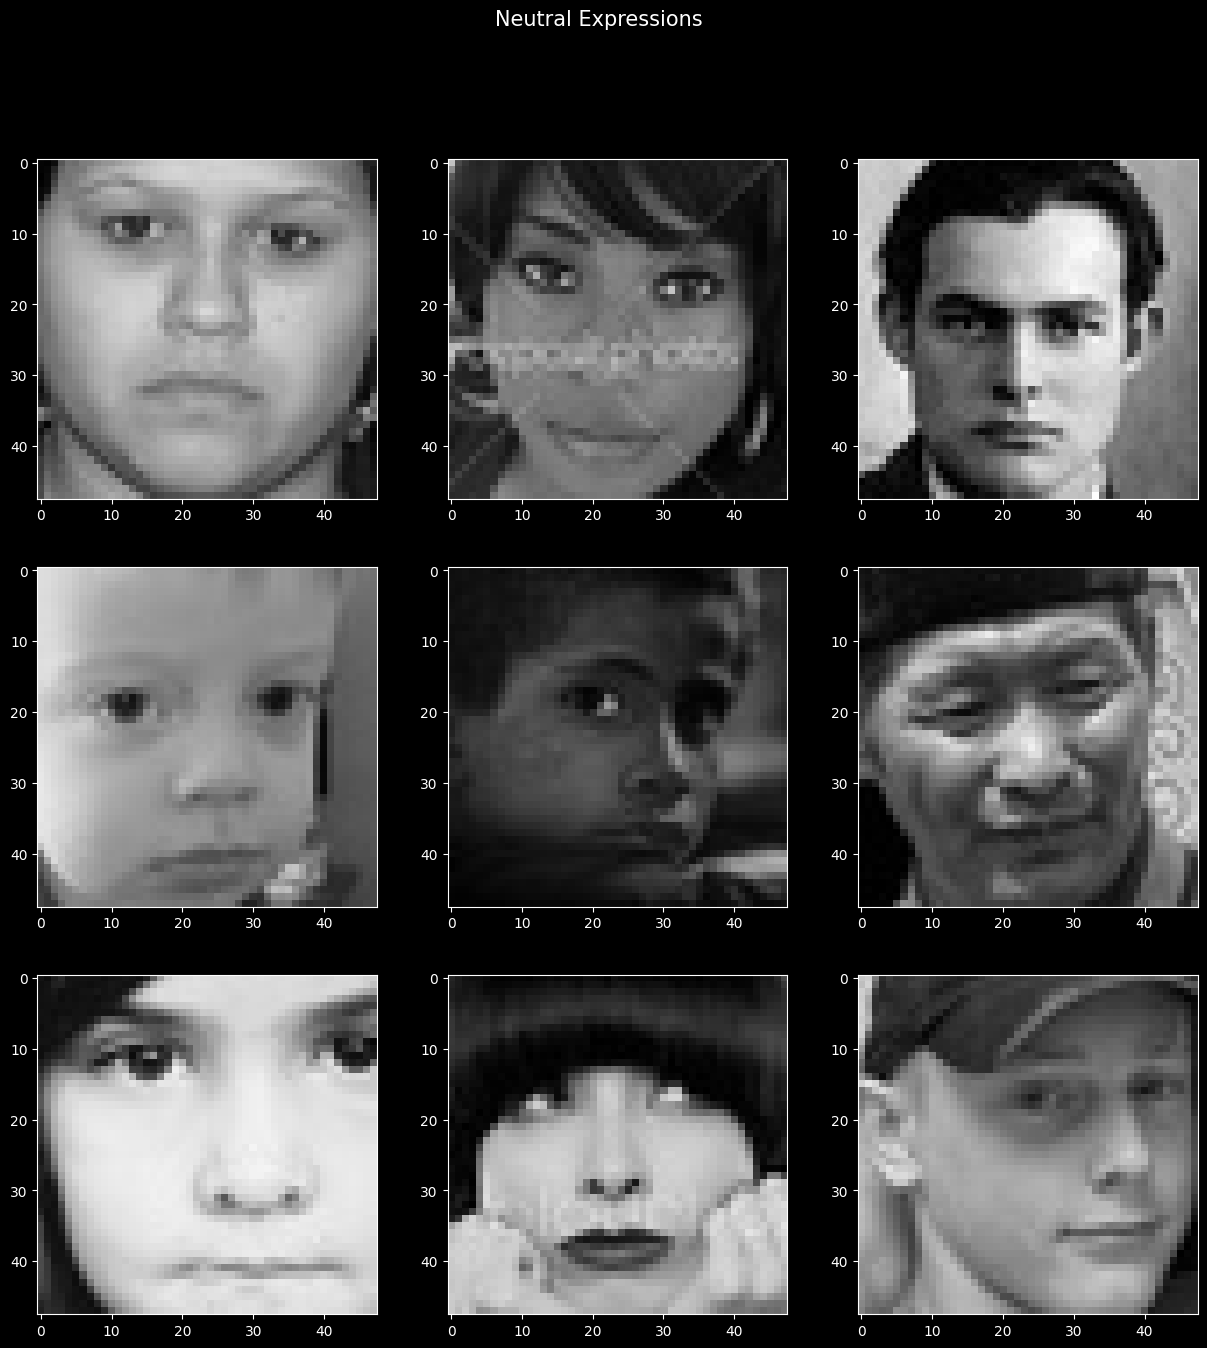

In [7]:
expression = 'neutral'
plt.style.use('dark_background')
plt.figure(figsize = (15, 15))
plt.suptitle('Neutral Expressions', fontsize = 15)
for i in range(1, 10, 1):
    plt.subplot(3, 3 ,i)
    plt.grid(False)
    img = load_img(train_dir + expression + '/' +
                  os.listdir(train_dir + expression)[i], target_size = (image_size))
    plt.imshow(img)
plt.show()

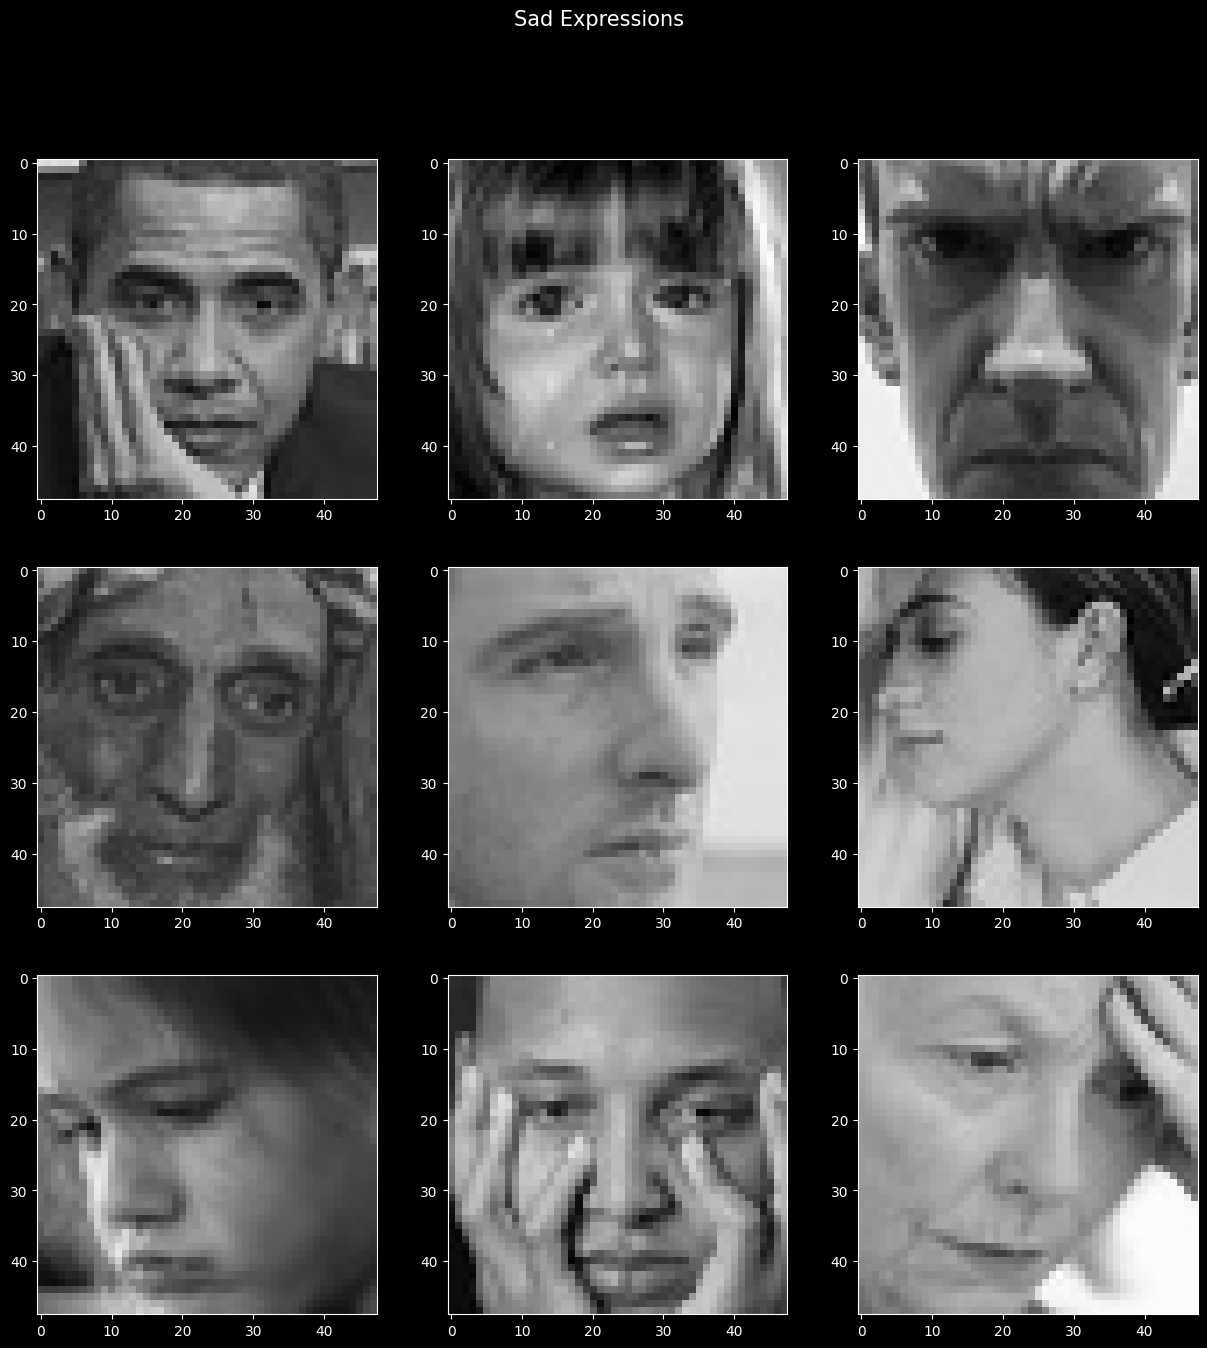

In [8]:
expression = 'sad'
plt.style.use('dark_background')
plt.figure(figsize = (15, 15))
plt.suptitle('Sad Expressions', fontsize = 15)
for i in range(1, 10, 1):
    plt.subplot(3, 3 ,i)
    plt.grid(False)
    img = load_img(train_dir + expression + '/' +
                  os.listdir(train_dir + expression)[i], target_size = (image_size))
    plt.imshow(img)
plt.show()

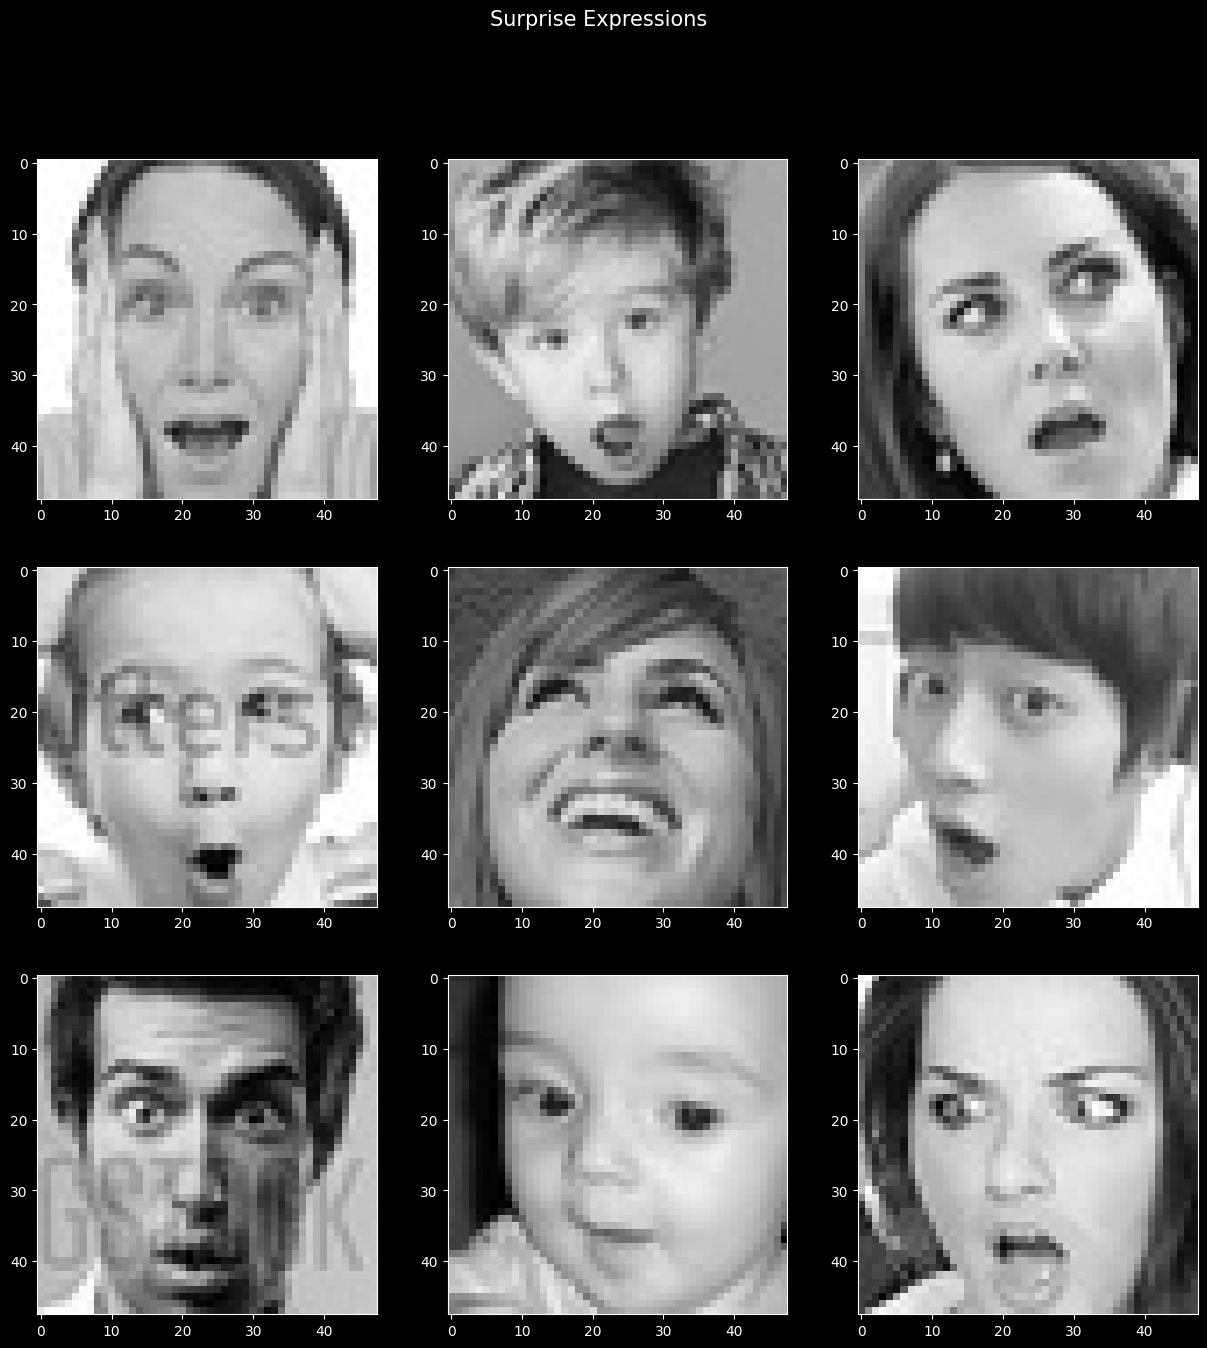

In [9]:
expression = 'surprise'
plt.style.use('dark_background')
plt.figure(figsize = (15, 15))
plt.suptitle('Surprise Expressions', fontsize = 15)
for i in range(1, 10, 1):
    plt.subplot(3, 3 ,i)
    plt.grid(False)
    img = load_img(train_dir + expression + '/' +
                  os.listdir(train_dir + expression)[i], target_size = (image_size))
    plt.imshow(img)
plt.show()

In [10]:
def count_exp(path, set_):
    '''
    This function is used to get the count of train, validation and test data.
    '''
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_dir, 'train')
val_count = count_exp(val_dir, 'test')
test_count = count_exp(test_dir, 'Main Test')

*The below graph represents the size of the dataset sperated into train and test in 6 different classes.*

<Figure size 2000x1000 with 0 Axes>

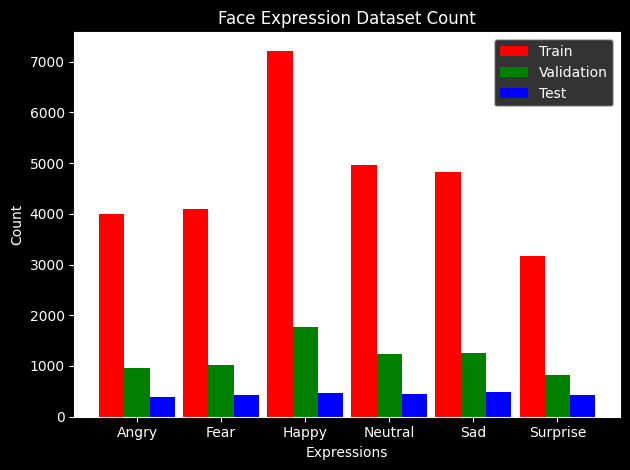

In [11]:
num_classes = 6
x = list(test_count.columns)
y1 = train_count.iloc[0].to_list()
y2 = val_count.iloc[0].to_list()
y3 = test_count.iloc[0].to_list()
plt.figure(figsize=(20,10))

fig, ax = plt.subplots()
ax.set_facecolor("white")
index = np.arange(num_classes)
bar_width = 0.3

rects1 = plt.bar(index, y1, bar_width,
color = 'r',
label = 'Train')

rects2 = plt.bar(index + bar_width, y2, bar_width,
color = 'g',
label = 'Validation')

rects3 = plt.bar(index + 2 * bar_width, y3, bar_width,
color = 'b',
label = 'Test')

plt.xlabel('Expressions')
plt.ylabel('Count')
plt.title('Face Expression Dataset Count')
plt.xticks(index + bar_width, (classes))
plt.legend()

plt.tight_layout()
plt.show()

### Data Augmentations

*The cell below shows the image augmentations performed on one of the images.*

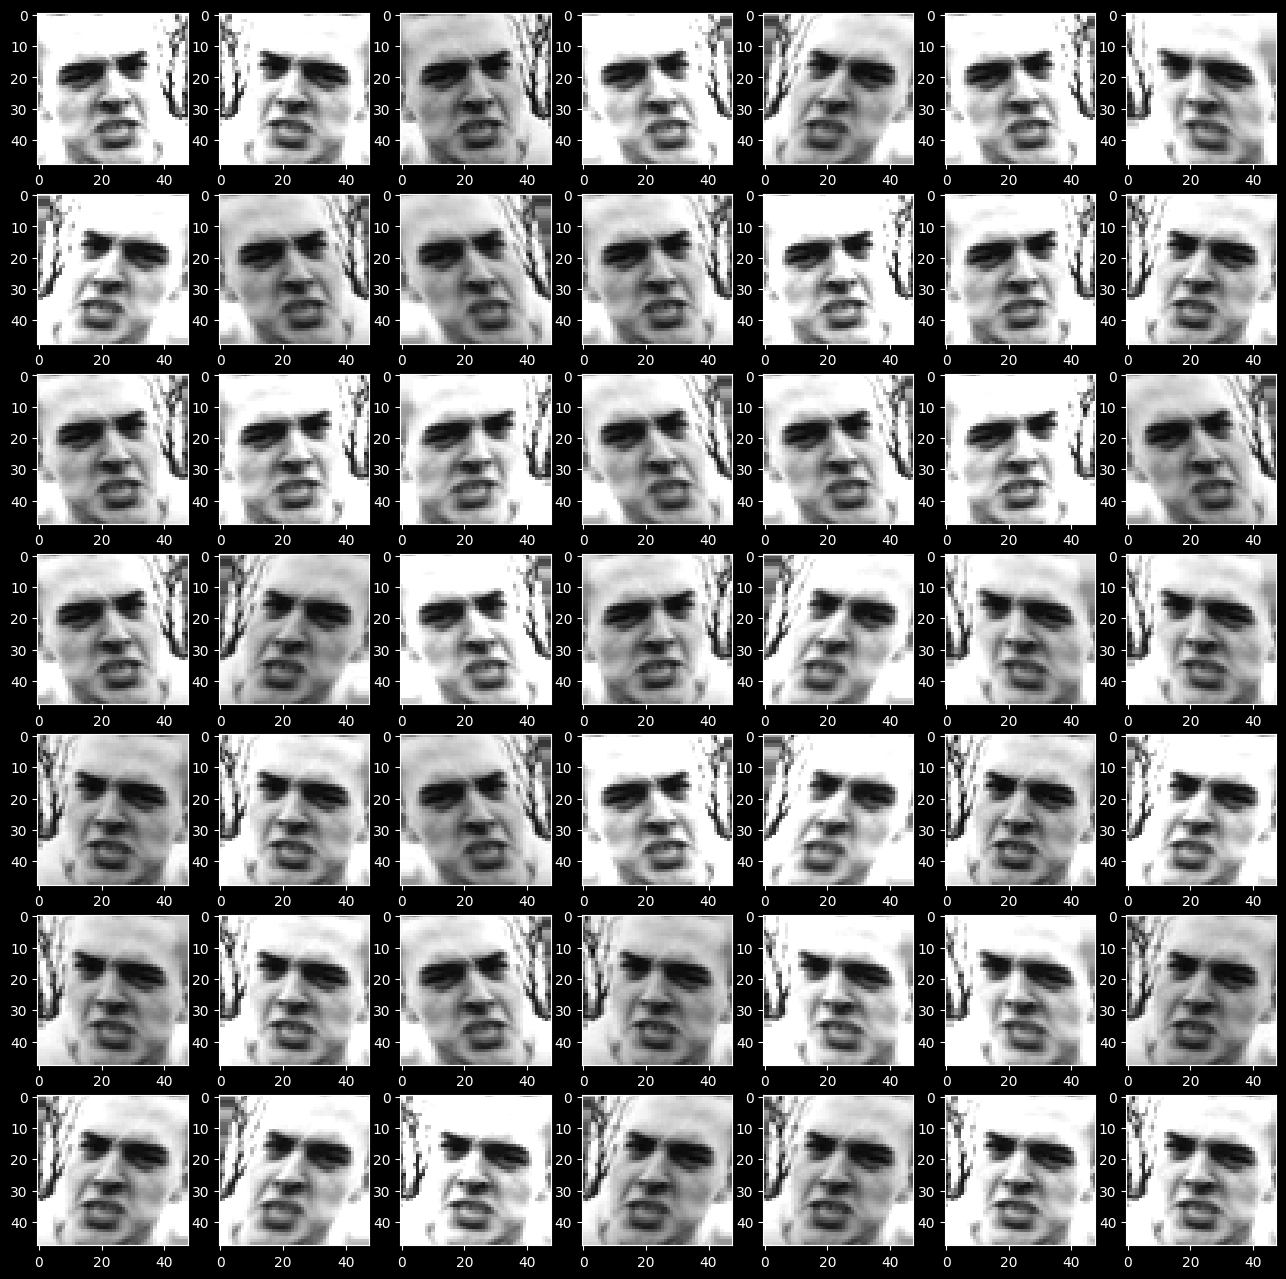

In [14]:
image_path = './../data/train/angry/Training_364963.jpg'
img = load_img(image_path, target_size = (48, 48))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

augment_test_datagen = ImageDataGenerator(horizontal_flip = True,
                                          brightness_range = [1, 1.5],
                                          shear_range = 15)

pic = augment_test_datagen.flow(img_tensor, batch_size = batch_size)
plt.figure(figsize=(16, 16))
#Plots our figures
for i in range(1,50):
   plt.subplot(7, 7, i)
   batch = pic.next()
   image_ = batch[0].astype('uint8')
   plt.imshow(image_)
plt.show()

*We need to generate the augmented data of the dataset using Image Data Generator for train, validation and test data. This is done to achieve different forms of same image which are augmented.*

In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   brightness_range = [1, 1.5],
                                   shear_range = 15)

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen  = ImageDataGenerator(rescale = 1./255)

*flow_from_dierectory method is used below to store the augmented data which is produced by the Image Data Generator.*

In [16]:
train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = image_size,
                                                   class_mode = 'categorical',
                                                   batch_size = batch_size,
                                                   shuffle = True)

validation_dataset = test_datagen.flow_from_directory(directory = val_dir,
                                                target_size = image_size,
                                                class_mode = 'categorical',
                                                batch_size = batch_size,
                                                shuffle = True)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                target_size = image_size,
                                                class_mode = 'categorical',
                                                batch_size = batch_size,
                                                shuffle = False)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.
Found 2660 images belonging to 6 classes.


*There are a total of 38,000 images in the dataset.*

*class_labels gives us different classes present in the dataset, train_sample is created to check the dimension of one of the image.*

In [17]:
class_labels = test_dataset.class_indices
train_sample=next(train_dataset)
print(train_sample[0].shape)

(128, 48, 48, 3)


### Modelling

*We declare the number of epochs and the patience level for callbacks below. Strategy is used to make use of the available GPUs. We make use of transfer learning which is nothing but the reusage of a previously learned model on a new problem. The reused model used below is VGG16.*

*About VGG16 Architecture: VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR (Imagenet) competition in 2014. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights.*

*The VGG16 is declared as the base model and some layers are frozen so as to avoid the change of weights during the course of training.*

In [18]:
epochs = 100
patience = 10

strategy = tf.distribute.MirroredStrategy( )
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
batch_size = batch_size * strategy.num_replicas_in_sync

with strategy.scope():
    base_model = tf.keras.applications.VGG16(input_shape = image_shape, include_top = False, weights = "imagenet")
    for layer in base_model.layers[:11]:
        layer.trainable=False
    
    model = Sequential()

    model.add(base_model)
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer = regularizers.l2(0.001), bias_regularizer = regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(64, activation = 'relu', kernel_regularizer = regularizers.l2(0.001), bias_regularizer = regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation="softmax"))
    
    metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
               tf.keras.metrics.AUC(name='auc')]
    adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     

*Compiling a model is required to finalise the model and make it completely ready to use. For compilation, we need to specify an optimizer and a loss function which is performed below.*

In [19]:
model.compile(optimizer = adam, loss='categorical_crossentropy', metrics = metrics)

*counter gives us the number of images in each class and max_val gives us the maximum number of images among all the classe. With the help of these 2 we calculate the class weights that is to be passed in model.fit. We calculate class_weights to address the issue of imbalanced dataset. Post this we define the 3 callbacks learning_rate, model_checkpoint, early_stopping. All of which are finally passed in model.fit.*

In [13]:
counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val / num_images, 2) for class_id, num_images in counter.items()}  
learning_rate = ReduceLROnPlateau(monitor = 'val_loss', patience = patience, verbose = 1, factor = 0.50, min_lr = 1e-10)
model_checkpoint = ModelCheckpoint('./../Models/vgg16_v2.h5')
early_stopping = EarlyStopping(verbose = 1, patience=20)

history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = epochs,
                    verbose = 1,
                    callbacks = [learning_rate, model_checkpoint, early_stopping], 
                    class_weight = class_weights,
                    batch_size = batch_size)

2022-11-29 11:09:45.785330: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\017TensorDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



Epoch 1/100
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1


2022-11-29 11:10:05.795974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2022-11-29 11:10:06.180905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2022-11-29 11:10:06.181909: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-29 11:10:06.608450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2022-11-29 11:10:07.092917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2022-11-29 11:10:09.852001: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f148000acb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-29 11:10:09.852055: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2022-11-29 11:10:09.852067: I tensorflow/compiler/xla

221/221 [==============================] - ETA: 0s - loss: 3.2164 - accuracy: 0.8167 - auc: 0.6506

2022-11-29 11:30:56.042514: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:41"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



221/221 [==============================] - 1581s 7s/step - loss: 3.2164 - accuracy: 0.8167 - auc: 0.6506 - val_loss: 2.5163 - val_accuracy: 0.7807 - val_auc: 0.6164 - lr: 1.0000e-04
Epoch 2/100
221/221 [==============================] - 1583s 7s/step - loss: 2.6608 - accuracy: 0.8420 - auc: 0.7589 - val_loss: 2.2492 - val_accuracy: 0.8183 - val_auc: 0.6552 - lr: 1.0000e-04
Epoch 3/100
221/221 [==============================] - 1350s 6s/step - loss: 2.4724 - accuracy: 0.8508 - auc: 0.7936 - val_loss: 1.7253 - val_accuracy: 0.8471 - val_auc: 0.7793 - lr: 1.0000e-04
Epoch 4/100
221/221 [==============================] - 1137s 5s/step - loss: 2.3565 - accuracy: 0.8554 - auc: 0.8115 - val_loss: 1.9874 - val_accuracy: 0.8391 - val_auc: 0.7774 - lr: 1.0000e-04
Epoch 5/100
221/221 [==============================] - 957s 4s/step - loss: 2.2515 - accuracy: 0.8600 - auc: 0.8294 - val_loss: 1.6862 - val_accuracy: 0.8383 - val_auc: 0.7975 - lr: 1.0000e-04
Epoch 6/100
221/221 [======================

*The below 3 cells are used to save the history and to recover the history and model at a later point when required. The first cell below should be used only if you train the model else the previously trained model and its files are present in the models folder.*

In [14]:
# import pickle 

# with open('./../Models/History/vgg16_v2.pkl', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

In [26]:
from tensorflow.keras.models import load_model

model = load_model("./../models/vgg_16.h5", compile = False)

In [28]:
import pickle

with open('./../models/history/vgg_16.pkl', "rb") as file_pi:
    history = pickle.load(file_pi)

### Evaluation and Predictions

*The below plots shows us the Loss, Accuracy and ROC of the model.*

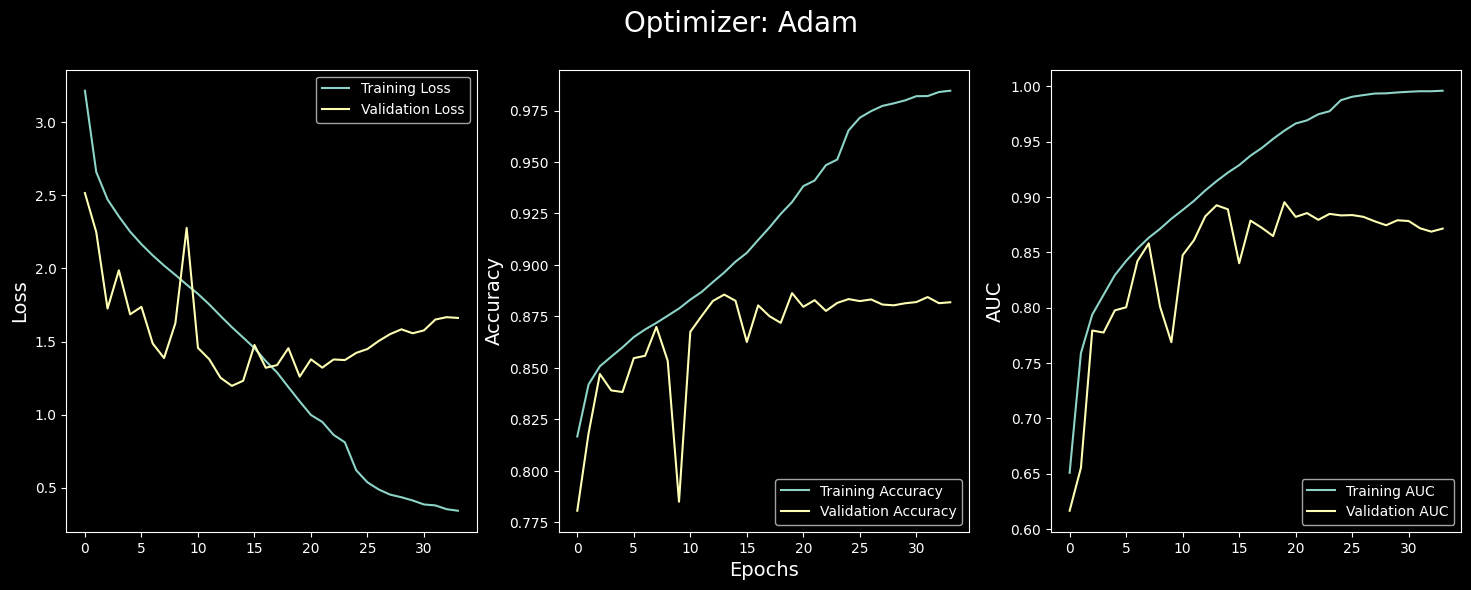

In [30]:
plt.style.use('dark_background')

plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.suptitle('Optimizer: Adam', fontsize = 20)
plt.ylabel('Loss', fontsize = 14)
#In the below 2 plot lines it should be history.history in case if you have trained the model and not used the pre-
#trained model.
plt.plot(history['loss'], label = 'Training Loss')
plt.plot(history['val_loss'], label = 'Validation Loss')
plt.legend(loc = 'upper right')

plt.subplot(1, 3, 2)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
#In the below 2 plot lines it should be history.history in case if you have trained the model and not used the pre-
#trained model.
plt.plot(history['accuracy'], label = 'Training Accuracy')
plt.plot(history['val_accuracy'], label = 'Validation Accuracy')
plt.legend(loc = 'lower right')

plt.subplot(1, 3, 3)
plt.ylabel('AUC', fontsize = 14)
#In the below 2 plot lines it should be history.history in case if you have trained the model and not used the pre-
#trained model.
plt.plot(history['auc'], label = 'Training AUC')
plt.plot(history['val_auc'], label = 'Validation AUC')
plt.legend(loc = 'lower right')

plt.savefig('./../models/plots/vgg_16_plot.jpg')
plt.show()

*The optimal seems to be somewhere between Epoch 15-20. Also the model has slighty overfit.*

*Predictions are performed in the cell below from the test dataset.*

In [31]:
predictions = model.predict(test_dataset)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_dataset.classes
class_names = test_dataset.class_indices.keys()

21/21 [==============================] - 69s 3s/step


*The below plot shows the Normalized Confusion Matrix.*

In [33]:
import itertools

def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Blues):
    '''
    This function is used to plot the Normalized Confusion Matrix.
    '''
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('./../models/confusion_matrix/vgg_16_comat.jpg')

<Figure size 640x480 with 0 Axes>

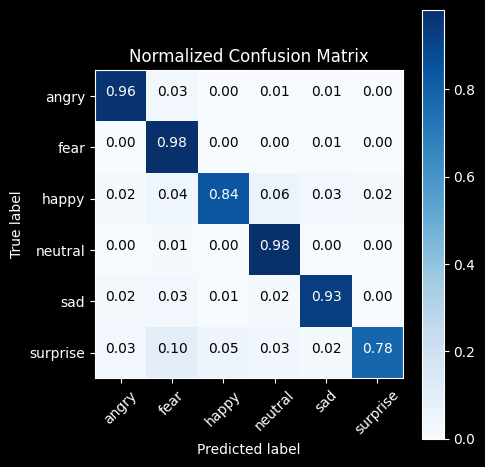

In [34]:
from sklearn.metrics import confusion_matrix

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision = 2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Normalized Confusion Matrix')
plt.show()

*4 classes angry, fear, neutral and sad have performed well with an accuracy of > 90%, happy has an accuracy of 84% and surprise at 78%.*

*The classification report is shown below.*

In [35]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names = test_dataset.class_indices.keys())
report_path = "./../models/classification_reports/vgg_16_classrep.txt"
text_file = open(report_path, "w")
n = text_file.write(report)
text_file.close()
print(report)

              precision    recall  f1-score   support

       angry       0.92      0.96      0.94       397
        fear       0.82      0.98      0.89       421
       happy       0.94      0.84      0.89       469
     neutral       0.89      0.98      0.93       450
         sad       0.94      0.93      0.93       486
    surprise       0.97      0.78      0.86       437

    accuracy                           0.91      2660
   macro avg       0.91      0.91      0.91      2660
weighted avg       0.91      0.91      0.91      2660



*The overall accuracy of the model on the test dataset is 91% which is better than the previous model which gave an accuracy of 89%.*